# 5.3

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../foot_traffic.csv')

df

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695
...,...
995,706.009031
996,705.610549
997,704.771335
998,703.559920


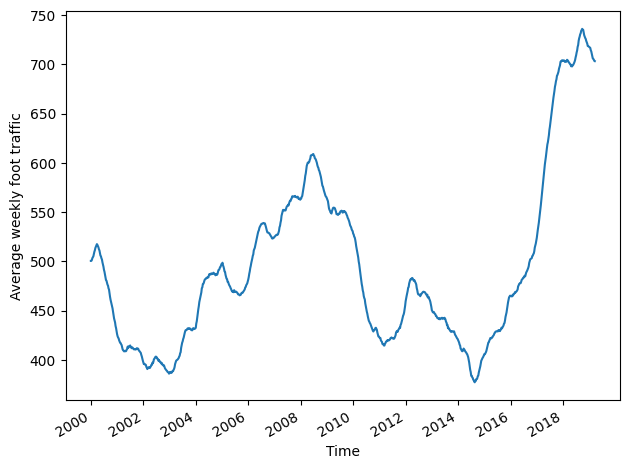

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['foot_traffic']
                      )
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240747
p-value: 0.683880891789619


In [ ]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

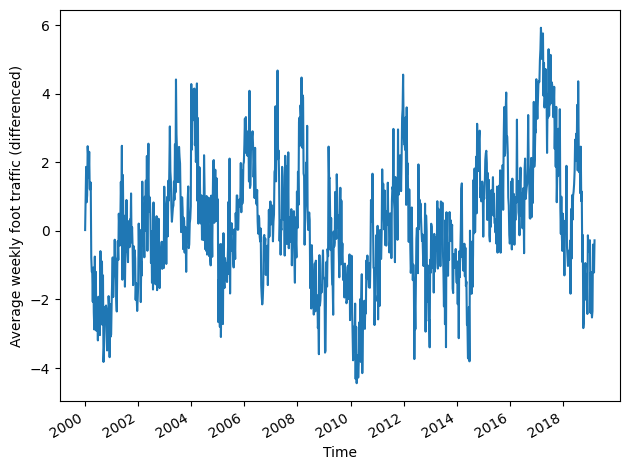

In [ ]:
fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
ADF_result = adfuller(foot_traffic_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.268231347422044
p-value: 6.369317654781239e-06


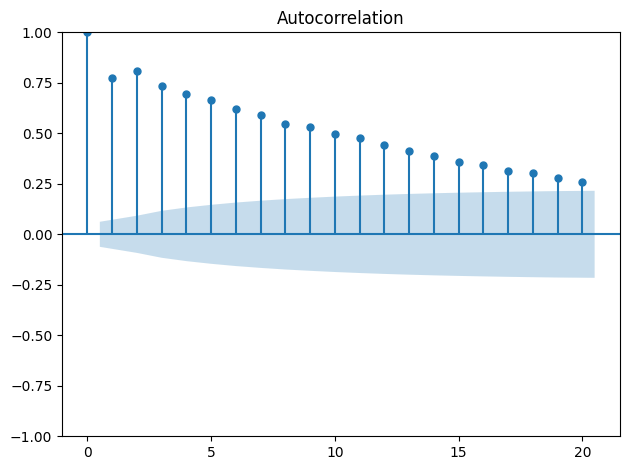

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(foot_traffic_diff, lags=20)
plt.tight_layout()

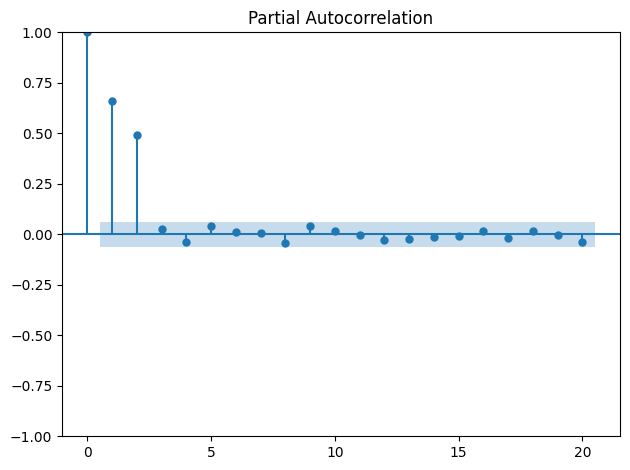

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(42)

ma2 =np.array([1,0,0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20)
plt.tight_layout()

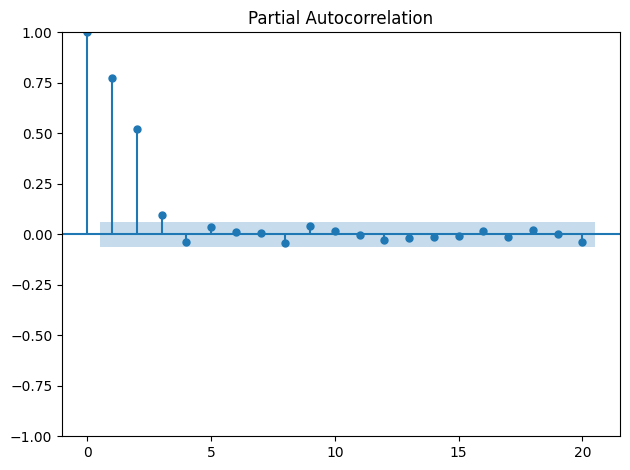

In [ ]:
plot_pacf(foot_traffic_diff, lags=20)
plt.tight_layout()

# 5.4

In [ ]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff.iloc[:-52]
test = df_diff.iloc[-52:]

print(len(train))
print(len(test))

947
52


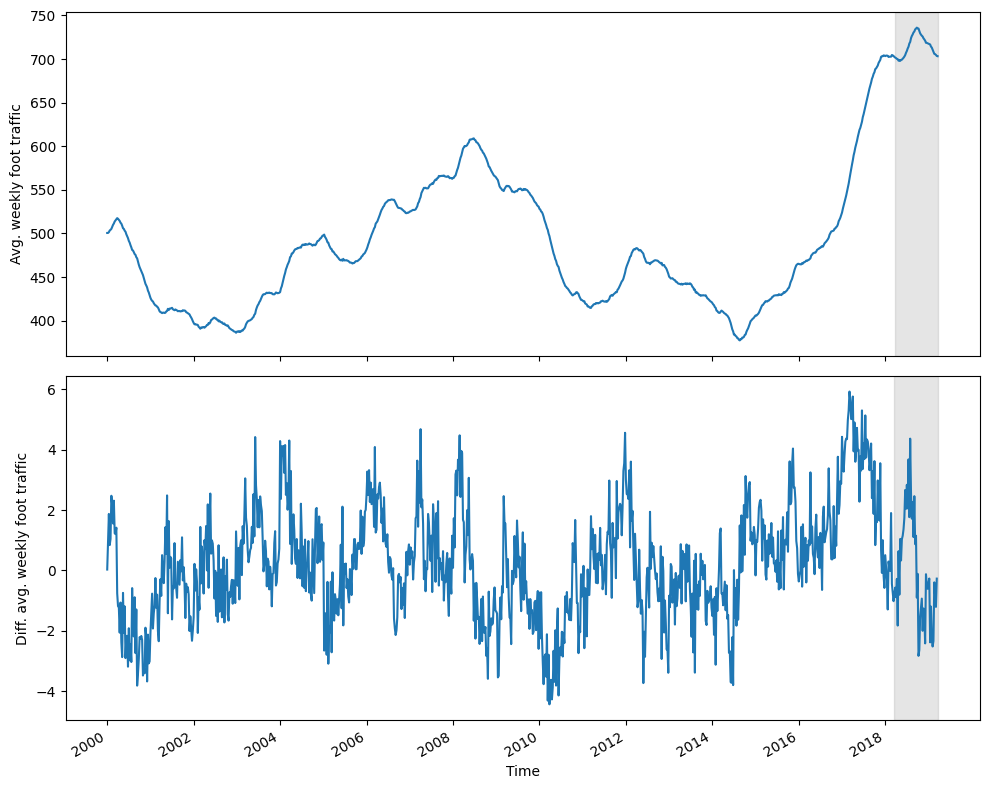

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame,train_len: int, horizon: int,
                     window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


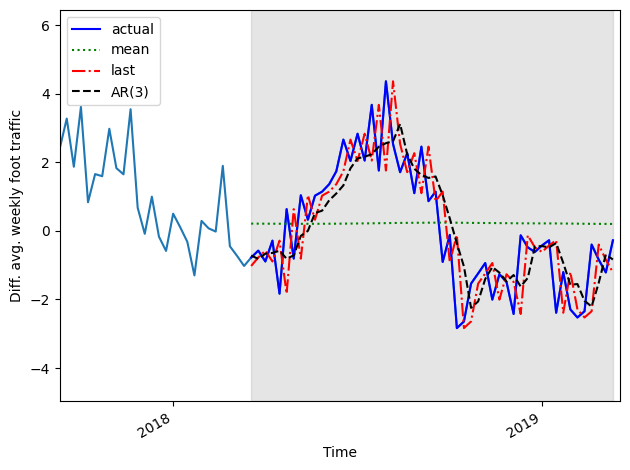

In [ ]:
fig, ax = plt.subplots()

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988], [2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.9242479164116852


In [ ]:
df['pred_foot_traffic'] = pd.Series()

df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

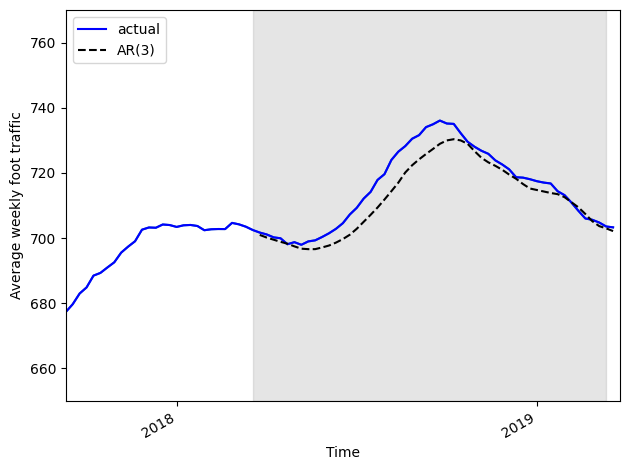

In [35]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988], [2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [37]:
from sklearn.metrics import mean_absolute_error

mape_AR_undiff = mean_absolute_error(df['foot_traffic'][948:],
                                     df['pred_foot_traffic'][948:])

print(mape_AR_undiff)

3.478033559658852


# 5.6　実習

In [3]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 =np.array([1,0,0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

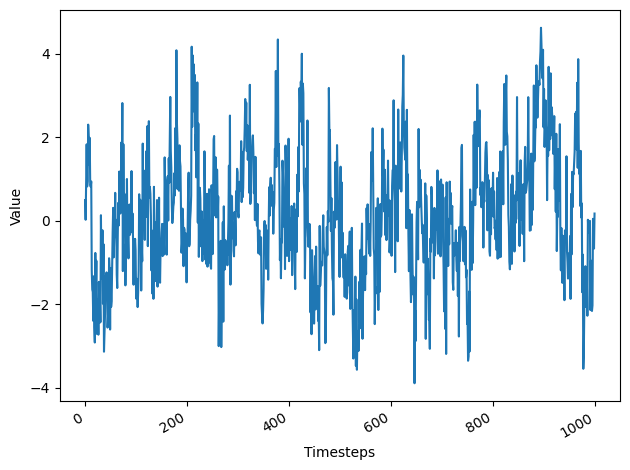

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(AR2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

In [9]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(AR2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.566606021416906
p-value: 2.9145161293762553e-11


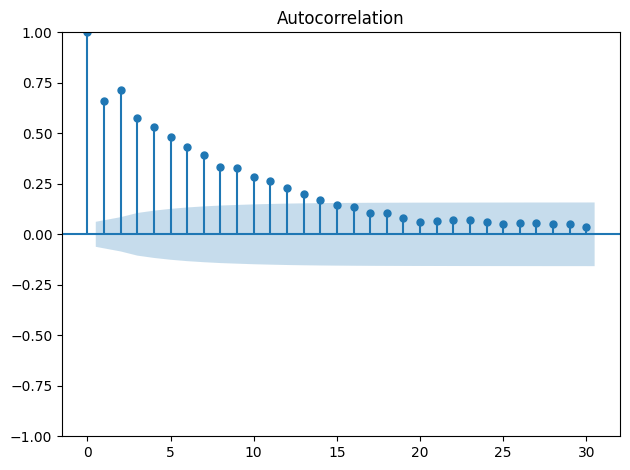

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(AR2_process, lags=30)
plt.tight_layout()

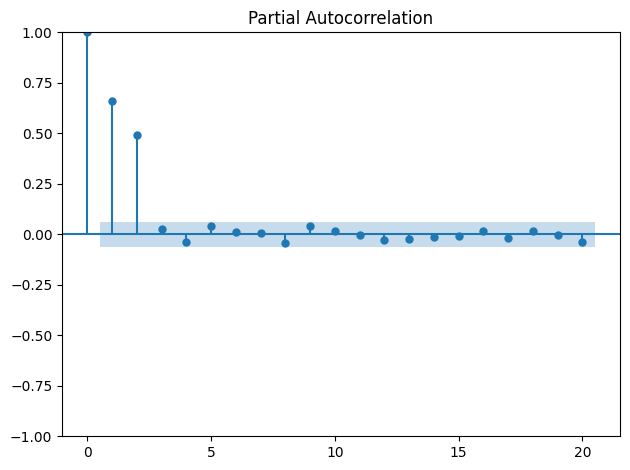

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20)
plt.tight_layout()

In [35]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame({'value': AR2_process})

train = df[:800]
test = df[800:]

print(len(train))
print(len(test))

800
200


In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame,train_len: int, horizon: int,
                     window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [39]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,value,pred_mean,pred_last_value,pred_AR
800,1.153388,-0.049737,0.461912,0.208203
801,0.095529,-0.049737,0.461912,0.289199
802,0.704340,-0.048056,0.095529,0.586307
803,-0.182079,-0.048056,0.095529,0.233598
804,-0.142412,-0.047287,-0.182079,0.281393


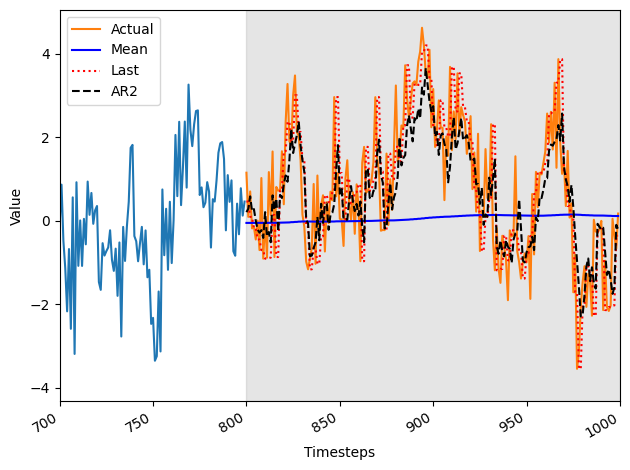

In [41]:
fig, ax = plt.subplots()

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_AR'], 'k--', label='AR2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

In [42]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_AR = mean_squared_error(test['value'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.0882016808214443 1.2111519051869672 0.9692635186184201


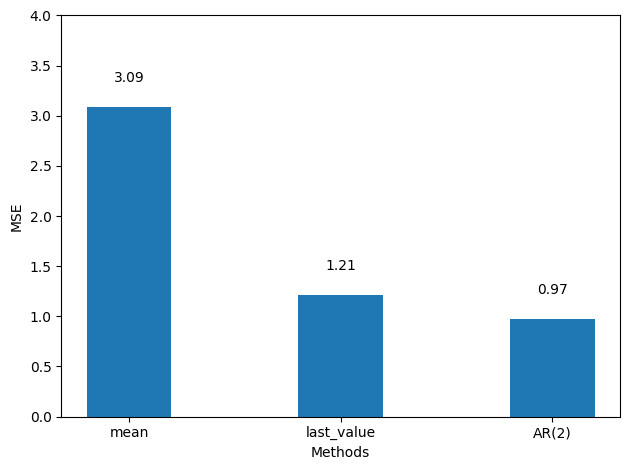

In [43]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(2)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [44]:
np.random.seed(42)

ma3 = np.array([1, 0, 0, 0])
ar3 = np.array([1, -0.33, -0.50, -0.07])

AR3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)

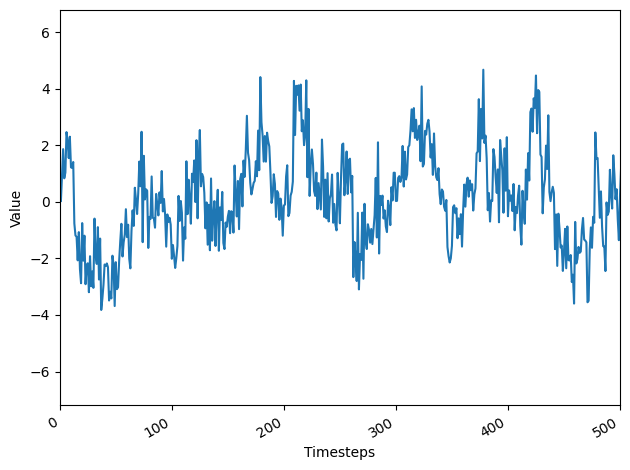

In [47]:
fig, ax = plt.subplots()

ax.plot(AR3_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(0, 500)

fig.autofmt_xdate()
plt.tight_layout()

In [48]:
ADF_result = adfuller(AR3_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -17.432292735214446
p-value: 4.7596122215787705e-30


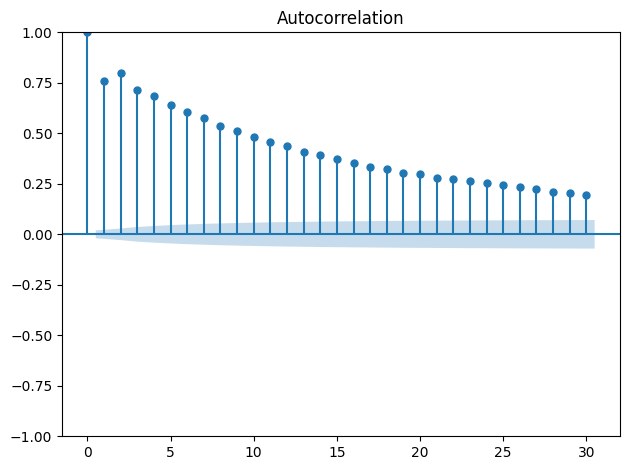

In [49]:
plot_acf(AR3_process, lags=30);

plt.tight_layout()

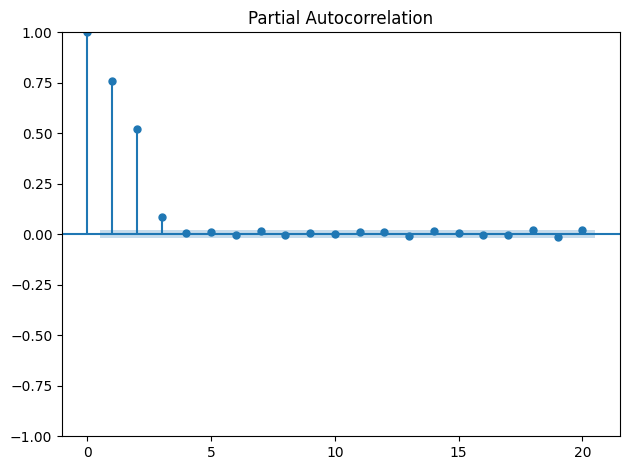

In [50]:
plot_pacf(AR3_process, lags=20);

plt.tight_layout()

In [51]:
AR3_df = pd.DataFrame({'value': AR3_process})

AR3_train = AR3_df[:-200]
AR3_test = AR3_df[-200:]

print(len(AR3_train))

9800


In [52]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [53]:
TRAIN_LEN = len(AR3_train)
HORIZON = len(AR3_test)
WINDOW = 2

pred_mean = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

AR3_test['pred_mean'] = pred_mean
AR3_test['pred_last_value'] = pred_last_value
AR3_test['pred_AR'] = pred_AR

AR3_test.head()

,value,pred_mean,pred_last_value,pred_AR
9800,0.251942,-0.019215,-1.360546,-0.654957
9801,-0.127163,-0.019215,-1.360546,-0.918610
9802,2.294406,-0.019199,-0.127163,-0.037953
9803,-0.304373,-0.019199,-0.127163,-0.051933
9804,1.860432,-0.018992,-0.304373,1.024416


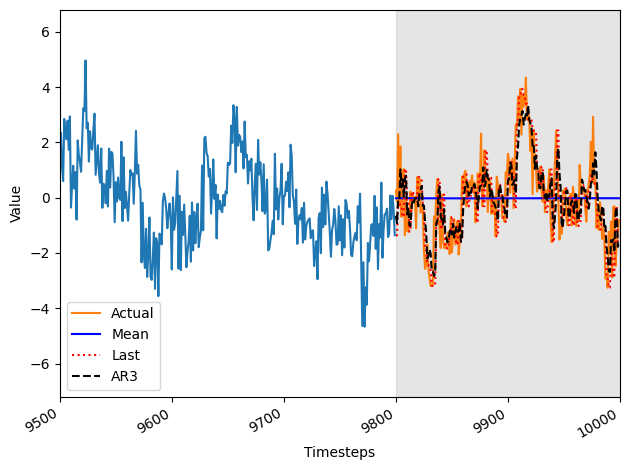

In [56]:
fig, ax = plt.subplots()

ax.plot(AR3_train)
ax.plot(AR3_test['value'], label='Actual')
ax.plot(AR3_test['pred_mean'], 'b-', label='Mean')
ax.plot(AR3_test['pred_last_value'], 'r:', label='Last')
ax.plot(AR3_test['pred_AR'], 'k--', label='AR3')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(9800, 10000, color='#808080', alpha=0.2)

plt.xlim(9500, 10000)
fig.autofmt_xdate()
plt.tight_layout()

In [57]:
mse_mean = mean_squared_error(AR3_test['value'], AR3_test['pred_mean'])
mse_last = mean_squared_error(AR3_test['value'], AR3_test['pred_last_value'])
mse_AR = mean_squared_error(AR3_test['value'], AR3_test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

2.136445934005893 1.2881802521489663 0.9969940312398288


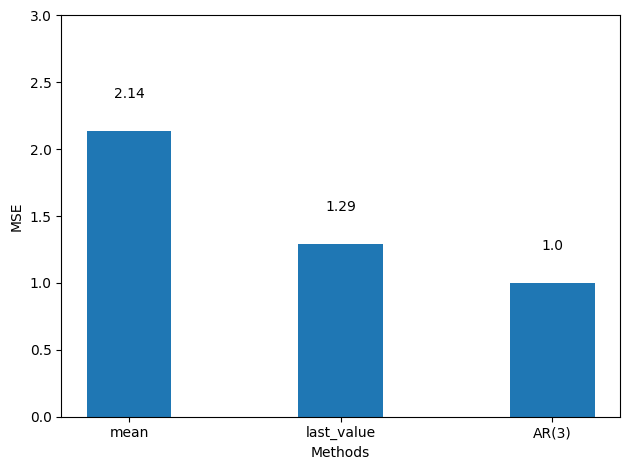

In [58]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()